In [29]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
import numpy as np

In [30]:
class OxfordIIITPetDataset(Dataset):
    @staticmethod
    def extract_breed(name):
        return ' '.join(name.split("_")[:-1]).lower().title()

    def __init__(self, img_dir, transform=None, transform_label=None):
        self.img_dir = img_dir
        self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
        self.transform = transform
        self.transform_label = transform_label
        self.labels = list(set([self.extract_breed(name) for name in self.image_names]))
        self.labels_to_idx = {item: idx for idx, item in enumerate(self.labels)}

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        label = self.extract_breed(image_name)
        label = self.labels_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

In [31]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
dataset = OxfordIIITPetDataset(img_dir='./Dataset/images', transform=transform)

train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2]) 
train_dl = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [33]:
def build_model(extra_layers=[], enable_batch_norm=False): # None to get the same as previous, int size of the layer
    pretrained_model = models.resnet18(weights="IMAGENET1K_V1")

    for parameter in pretrained_model.parameters():
        parameter.requires_grad = False

    new_layers = []
    previous = pretrained_model.fc.in_features
    for m in extra_layers:
        if m is None:
            m = previous
        new_layers.append(nn.Linear(previous, m))
        if enable_batch_norm:
            new_layers.append(nn.BatchNorm1d(m))
        new_layers.append(nn.ReLU(inplace=True))
        previous = m

    new_layers.append(nn.Linear(previous, len(dataset.labels)))
    if enable_batch_norm:
        new_layers.append(nn.BatchNorm1d(len(dataset.labels)))


    pretrained_model.fc = nn.Sequential(*new_layers)
    return pretrained_model

In [34]:
def test_accuracy(model: OxfordIIITPetDataset, test_loader: DataLoader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Move inputs to device (CPU or GPU)
            labels = labels.to(device)  # Move labels to device (CPU or GPU)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    return accuracy

In [35]:
def train_model(model: OxfordIIITPetDataset, train_loader: DataLoader, val_loader, optimizer, epochs, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    accuracies = []
    learning_rates = []

    loss_func = nn.CrossEntropyLoss()
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()

        i = 0

        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            lr = optimizer.param_groups[0]['lr']
            learning_rates.append(lr)

            # print statistics
            running_loss += loss.item()
            i += train_loader.batch_size
            if i % 2000 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        acc = test_accuracy(model, val_loader)
        accuracies.append(acc)
        print("Finished %s epoch with validation accuracy: %s" % (epoch + 1, acc))

    print('Finished Training')
    return accuracies, learning_rates

In [36]:
def plot_accuracies(accuracies):
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.grid(True)
    plt.show()

def plot_lr(lr):
    plt.plot(lr, marker='o', linestyle='-')
    plt.xlabel('Updates steps')
    plt.ylabel('Learning rate')
    plt.title('Learning rate over Updates steps')
    plt.grid(True)
    plt.show()

In [37]:
def main(extra_layers, epochs=5, sched=None, enable_batch_norm=False):
    pretrained_model = build_model(extra_layers, enable_batch_norm=enable_batch_norm)

    optimizer = torch.optim.Adam(pretrained_model.parameters())

    scheduler = None

    if sched == 1:
        step_size = (len(train_dl.dataset) // train_dl.batch_size) // 2
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.9)

    accuracies, learning_rates = train_model(pretrained_model, train_dl, test_dl, optimizer, epochs=epochs, scheduler=scheduler)

    acc = test_accuracy(pretrained_model, test_dl)
    print('Accuracy on test data: %s' % acc)

    plot_accuracies(accuracies)
    if sched is not None:
        plot_lr(learning_rates)

## Trying different layers

[1,  2001] loss: 0.030
[1,  4001] loss: 0.019
Finished 1 epoch with validation accuracy: 0.7368064952638701
[2,  2001] loss: 0.011
[2,  4001] loss: 0.009
Finished 2 epoch with validation accuracy: 0.8382949932341002
[3,  2001] loss: 0.007
[3,  4001] loss: 0.006
Finished 3 epoch with validation accuracy: 0.8430311231393776
[4,  2001] loss: 0.006
[4,  4001] loss: 0.005
Finished 4 epoch with validation accuracy: 0.8606224627875507
[5,  2001] loss: 0.005
[5,  4001] loss: 0.004
Finished 5 epoch with validation accuracy: 0.8802435723951285
Finished Training
Accuracy on test data: 0.8870094722598105


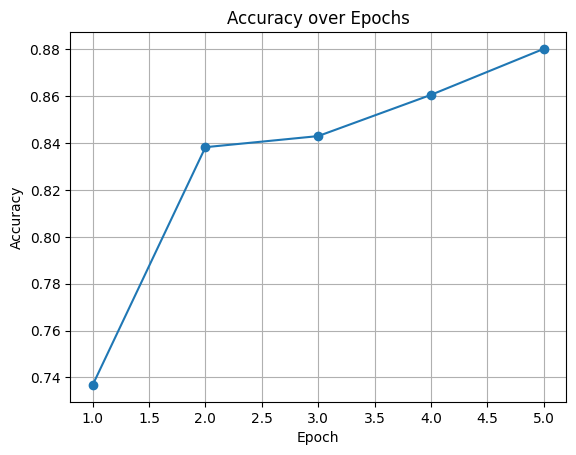

In [13]:
main(extra_layers=[], epochs=5)

[1,  2001] loss: 0.025
[1,  4001] loss: 0.011
Finished 1 epoch with validation accuracy: 0.8207036535859269
[2,  2001] loss: 0.006
[2,  4001] loss: 0.005
Finished 2 epoch with validation accuracy: 0.8437077131258457
[3,  2001] loss: 0.004
[3,  4001] loss: 0.004
Finished 3 epoch with validation accuracy: 0.8700947225981055
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
Finished 4 epoch with validation accuracy: 0.8802435723951285
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
Finished 5 epoch with validation accuracy: 0.8626522327469553
Finished Training
Accuracy on test data: 0.8633288227334236


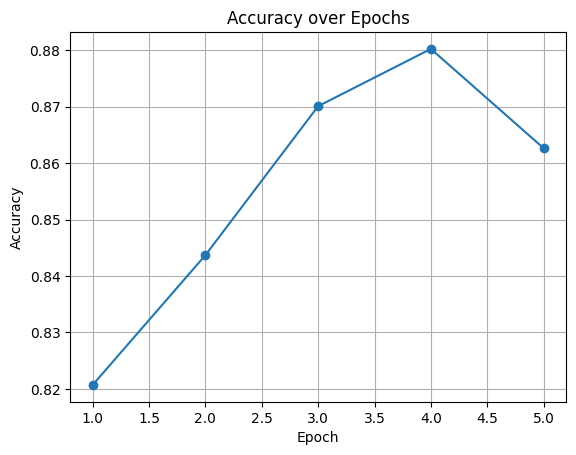

In [12]:
main(extra_layers=[None], epochs=5)

[1,  2001] loss: 0.026
[1,  4001] loss: 0.010
Finished 1 epoch with validation accuracy: 0.7794316644113667
[2,  2001] loss: 0.006
[2,  4001] loss: 0.005
Finished 2 epoch with validation accuracy: 0.8389715832205683
[3,  2001] loss: 0.005
[3,  4001] loss: 0.004
Finished 3 epoch with validation accuracy: 0.8606224627875507
[4,  2001] loss: 0.003
[4,  4001] loss: 0.004
Finished 4 epoch with validation accuracy: 0.8572395128552097
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
Finished 5 epoch with validation accuracy: 0.8673883626522327
Finished Training
Accuracy on test data: 0.8687415426251691


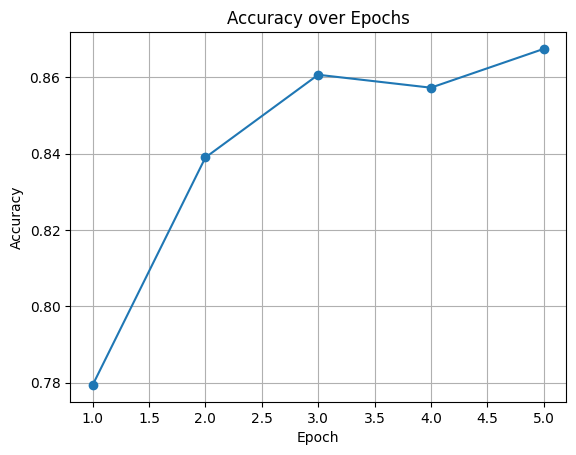

In [13]:
main(extra_layers=[None, None])

## Trying decaying learning rate

[1,  2001] loss: 0.030
[1,  4001] loss: 0.019
Finished 1 epoch with validation accuracy: 0.7821380243572396
[2,  2001] loss: 0.011
[2,  4001] loss: 0.010
Finished 2 epoch with validation accuracy: 0.8335588633288228
[3,  2001] loss: 0.008
[3,  4001] loss: 0.007
Finished 3 epoch with validation accuracy: 0.854533152909337
[4,  2001] loss: 0.006
[4,  4001] loss: 0.006
Finished 4 epoch with validation accuracy: 0.8538565629228687
[5,  2001] loss: 0.006
[5,  4001] loss: 0.006
Finished 5 epoch with validation accuracy: 0.8734776725304465
Finished Training
Accuracy on test data: 0.8700947225981055


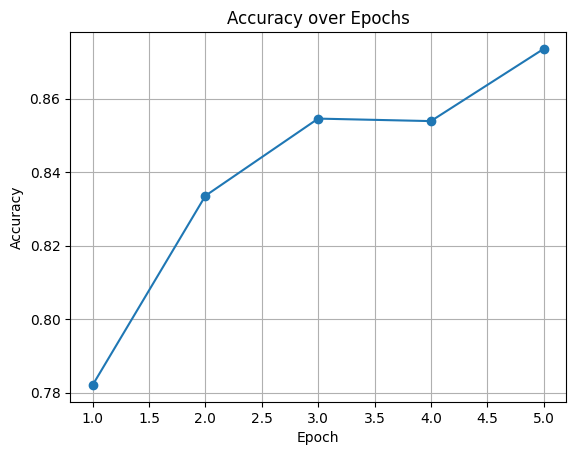

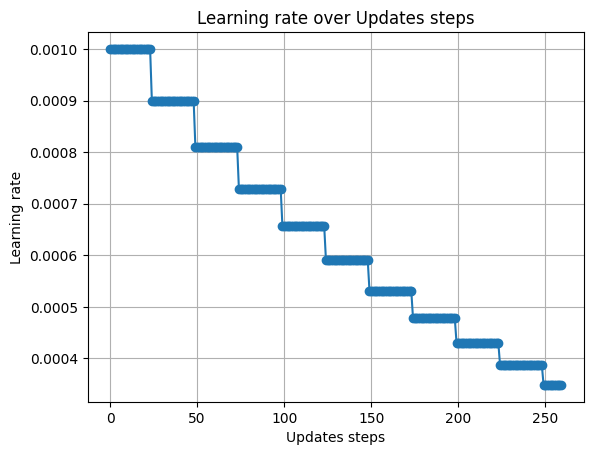

In [27]:
main(extra_layers=[], epochs=5, sched=1)

[1,  2001] loss: 0.025
[1,  4001] loss: 0.011
Finished 1 epoch with validation accuracy: 0.8382949932341002
[2,  2001] loss: 0.005
[2,  4001] loss: 0.005
Finished 2 epoch with validation accuracy: 0.851150202976996
[3,  2001] loss: 0.004
[3,  4001] loss: 0.004
Finished 3 epoch with validation accuracy: 0.8883626522327469
[4,  2001] loss: 0.003
[4,  4001] loss: 0.003
Finished 4 epoch with validation accuracy: 0.8856562922868741
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
Finished 5 epoch with validation accuracy: 0.8930987821380244
Finished Training
Accuracy on test data: 0.8755074424898511


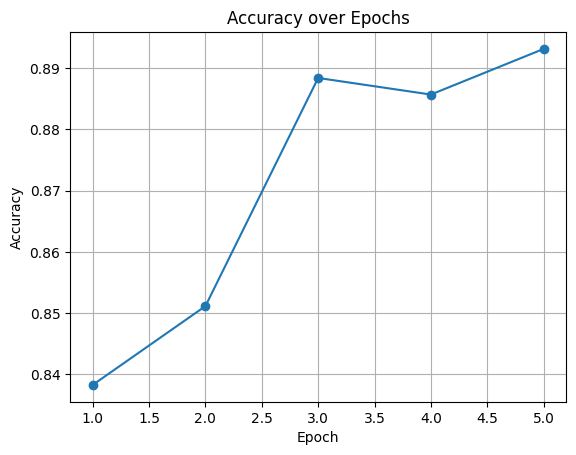

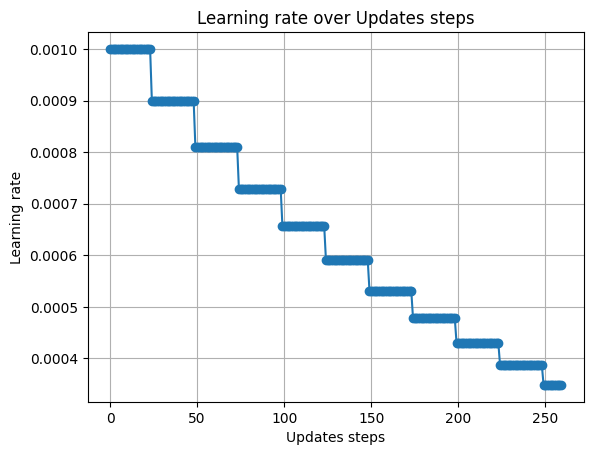

In [29]:
main(extra_layers=[None], epochs=5, sched=1)

[1,  2001] loss: 0.026
[1,  4001] loss: 0.010
Finished 1 epoch with validation accuracy: 0.8186738836265224
[2,  2001] loss: 0.005
[2,  4001] loss: 0.005
Finished 2 epoch with validation accuracy: 0.8294993234100135
[3,  2001] loss: 0.004
[3,  4001] loss: 0.004
Finished 3 epoch with validation accuracy: 0.8741542625169147
[4,  2001] loss: 0.004
[4,  4001] loss: 0.003
Finished 4 epoch with validation accuracy: 0.8687415426251691
[5,  2001] loss: 0.003
[5,  4001] loss: 0.003
Finished 5 epoch with validation accuracy: 0.8856562922868741
Finished Training
Accuracy on test data: 0.8897158322056834


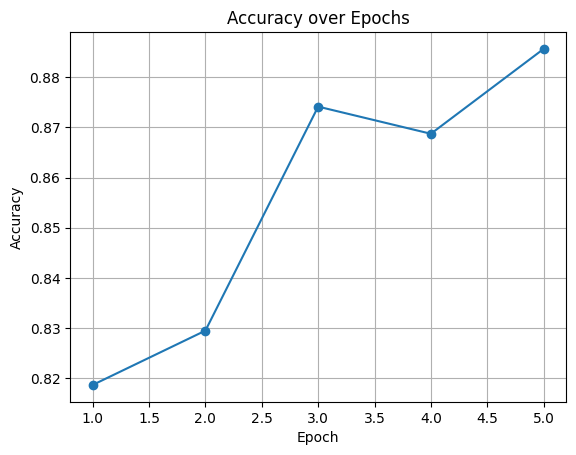

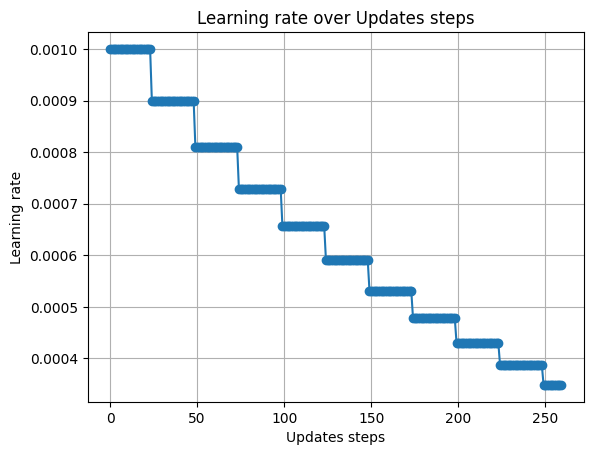

In [30]:
main(extra_layers=[None, None], epochs=5, sched=1)

## Batch normalization

[1,  2001] loss: 0.026
[1,  4001] loss: 0.016
Finished 1 epoch with validation accuracy: 0.7956698240866035
[2,  2001] loss: 0.012
[2,  4001] loss: 0.011
Finished 2 epoch with validation accuracy: 0.8416779431664412
[3,  2001] loss: 0.010
[3,  4001] loss: 0.010
Finished 3 epoch with validation accuracy: 0.8497970230040596
[4,  2001] loss: 0.009
[4,  4001] loss: 0.009
Finished 4 epoch with validation accuracy: 0.8552097428958051
[5,  2001] loss: 0.009
[5,  4001] loss: 0.009
Finished 5 epoch with validation accuracy: 0.8558863328822733
Finished Training
Accuracy on test data: 0.8599458728010826


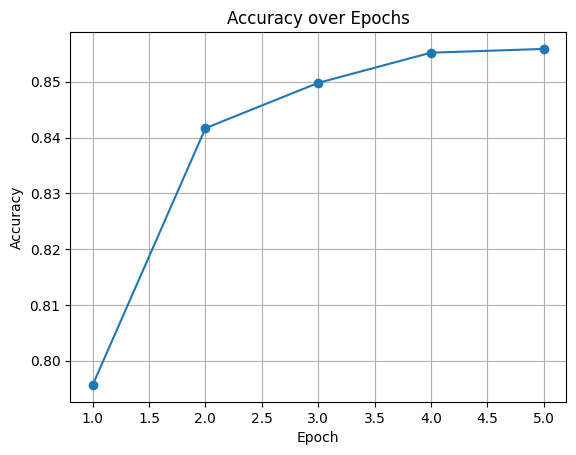

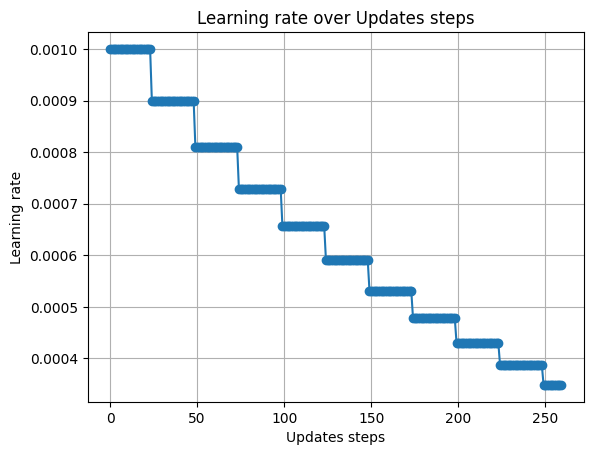

In [14]:
main(extra_layers=[], epochs=5, sched=1, enable_batch_norm=True)

[1,  2001] loss: 0.017
[1,  4001] loss: 0.010
Finished 1 epoch with validation accuracy: 0.8728010825439784
[2,  2001] loss: 0.008
[2,  4001] loss: 0.007
Finished 2 epoch with validation accuracy: 0.8843031123139378
[3,  2001] loss: 0.006
[3,  4001] loss: 0.006
Finished 3 epoch with validation accuracy: 0.8870094722598105
[4,  2001] loss: 0.006
[4,  4001] loss: 0.006
Finished 4 epoch with validation accuracy: 0.8843031123139378
[5,  2001] loss: 0.005
[5,  4001] loss: 0.005
Finished 5 epoch with validation accuracy: 0.8971583220568335
Finished Training
Accuracy on test data: 0.8897158322056834


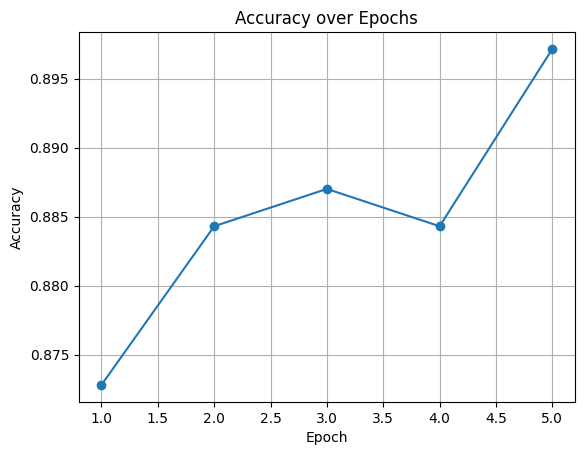

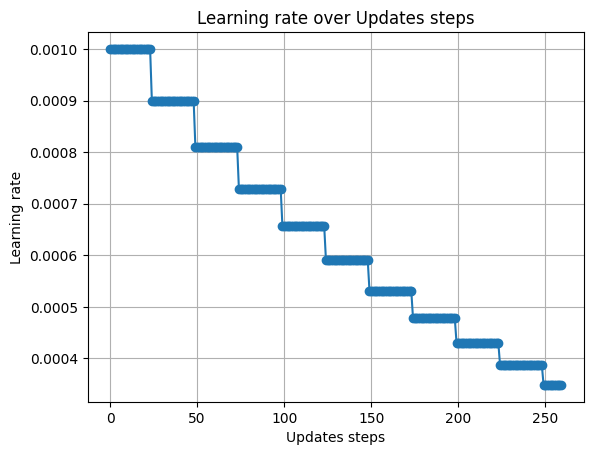

In [15]:
main(extra_layers=[None], epochs=5, sched=1, enable_batch_norm=True)

[1,  2001] loss: 0.016
[1,  4001] loss: 0.009
Finished 1 epoch with validation accuracy: 0.8673883626522327
[2,  2001] loss: 0.007
[2,  4001] loss: 0.007
Finished 2 epoch with validation accuracy: 0.8768606224627875
[3,  2001] loss: 0.005
[3,  4001] loss: 0.006
Finished 3 epoch with validation accuracy: 0.8924221921515562
[4,  2001] loss: 0.005
[4,  4001] loss: 0.005
Finished 4 epoch with validation accuracy: 0.8876860622462788
[5,  2001] loss: 0.004
[5,  4001] loss: 0.004
Finished 5 epoch with validation accuracy: 0.8958051420838972
Finished Training
Accuracy on test data: 0.8937753721244925


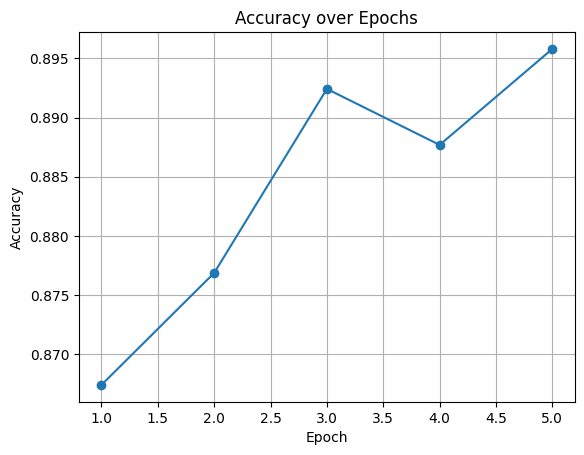

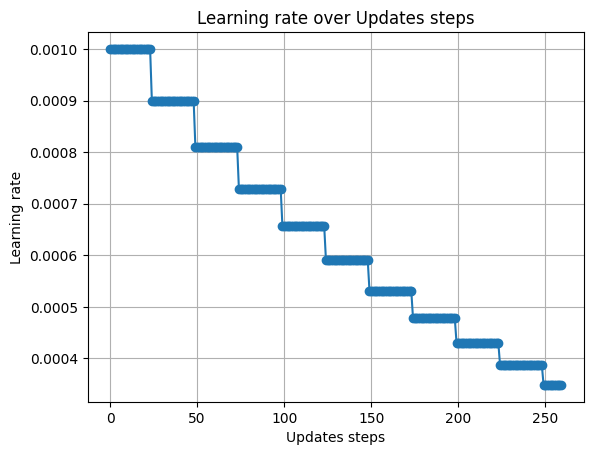

In [16]:
main(extra_layers=[None, None], epochs=5, sched=1, enable_batch_norm=True)

## Final

[1,  2001] loss: 0.018
[1,  4001] loss: 0.011
Finished 1 epoch with validation accuracy: 0.8558863328822733
[2,  2001] loss: 0.009
[2,  4001] loss: 0.008
Finished 2 epoch with validation accuracy: 0.8761840324763194
[3,  2001] loss: 0.007
[3,  4001] loss: 0.007
Finished 3 epoch with validation accuracy: 0.8721244925575101
[4,  2001] loss: 0.006
[4,  4001] loss: 0.006
Finished 4 epoch with validation accuracy: 0.8822733423545331
[5,  2001] loss: 0.006
[5,  4001] loss: 0.006
Finished 5 epoch with validation accuracy: 0.8836265223274695
[6,  2001] loss: 0.005
[6,  4001] loss: 0.005
Finished 6 epoch with validation accuracy: 0.8822733423545331
[7,  2001] loss: 0.005
[7,  4001] loss: 0.005
Finished 7 epoch with validation accuracy: 0.8788903924221921
[8,  2001] loss: 0.005
[8,  4001] loss: 0.005
Finished 8 epoch with validation accuracy: 0.8944519621109608
[9,  2001] loss: 0.005
[9,  4001] loss: 0.005
Finished 9 epoch with validation accuracy: 0.8958051420838972
[10,  2001] loss: 0.005
[10,

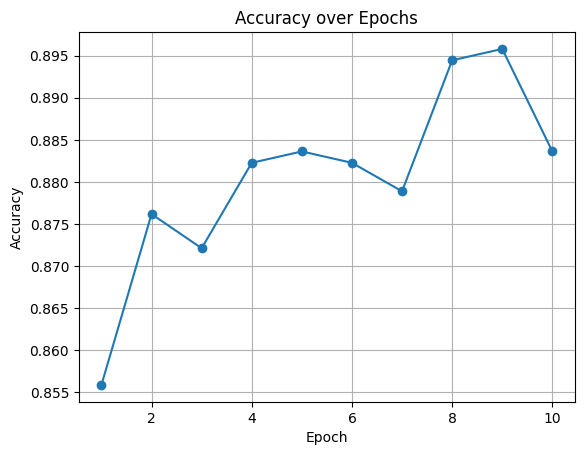

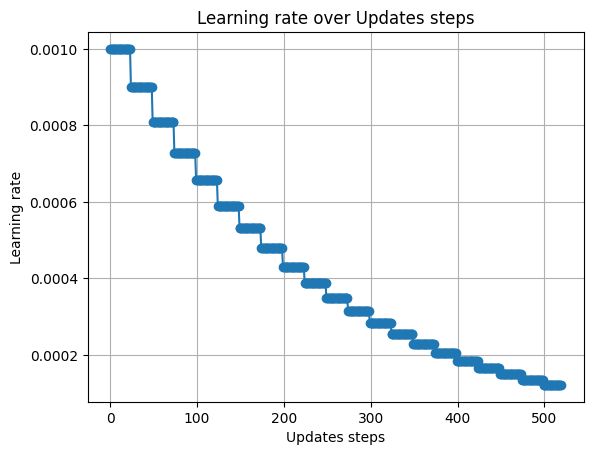

In [38]:
main(extra_layers=[None], epochs=10, sched=1, enable_batch_norm=True)

[1,  2001] loss: 0.017
[1,  4001] loss: 0.010
Finished 1 epoch with validation accuracy: 0.8565629228687416
[2,  2001] loss: 0.007
[2,  4001] loss: 0.007
Finished 2 epoch with validation accuracy: 0.8829499323410014
[3,  2001] loss: 0.006
[3,  4001] loss: 0.006
Finished 3 epoch with validation accuracy: 0.8802435723951285
[4,  2001] loss: 0.005
[4,  4001] loss: 0.005
Finished 4 epoch with validation accuracy: 0.8890392422192152
[5,  2001] loss: 0.005
[5,  4001] loss: 0.005
Finished 5 epoch with validation accuracy: 0.8870094722598105
[6,  2001] loss: 0.004
[6,  4001] loss: 0.004
Finished 6 epoch with validation accuracy: 0.8985115020297699
[7,  2001] loss: 0.004
[7,  4001] loss: 0.004
Finished 7 epoch with validation accuracy: 0.8829499323410014
[8,  2001] loss: 0.004
[8,  4001] loss: 0.004
Finished 8 epoch with validation accuracy: 0.8937753721244925
[9,  2001] loss: 0.004
[9,  4001] loss: 0.004
Finished 9 epoch with validation accuracy: 0.8876860622462788
[10,  2001] loss: 0.004
[10,

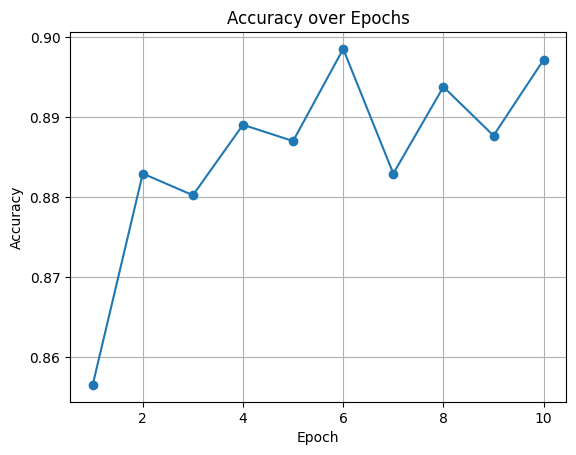

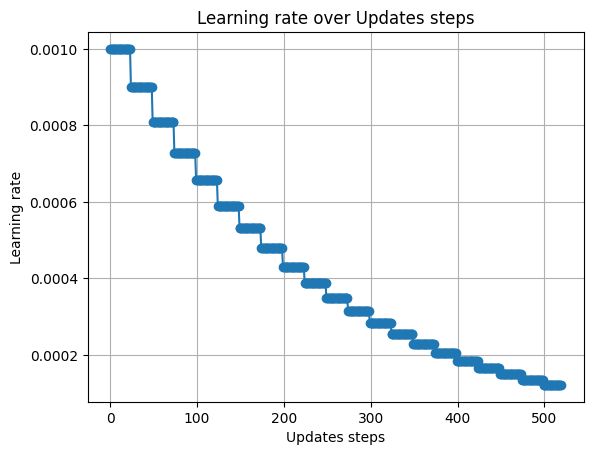

In [39]:
main(extra_layers=[None, None], epochs=10, sched=1, enable_batch_norm=True)